# Домашнее задание «Сверточные нейронные сети: практическое применение»

In [2]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.8.0
True


### Функции загрузки данных

In [3]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('data/train_sample/*.jpg')
test_files = glob('data/test_sample/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

### Визуализируем примеры для обучения

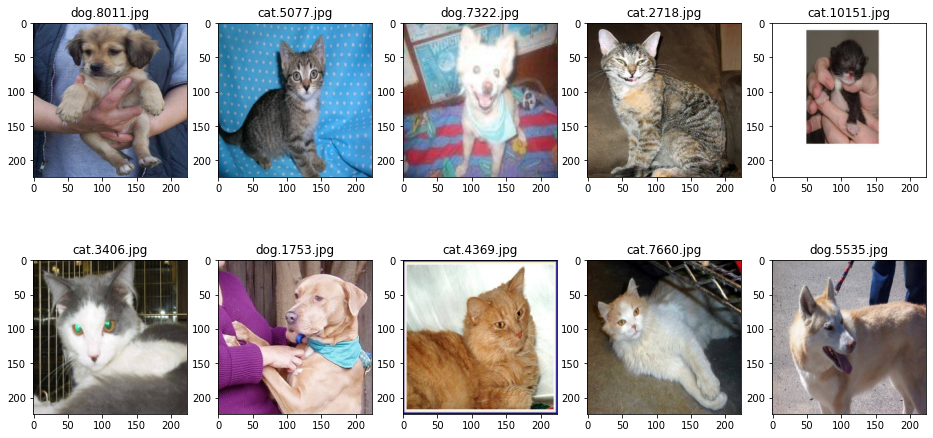

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)


### Загружаем предобученную модель

In [5]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58900480/58889256 [==============================] - 8s 0us/step


### Добавляем полносвязный слой

In [44]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

Помимо выходного полносвязного слоя я добавил два слоя с BatchNormalization и один полносвязный слой на 256 нейронов между ними для улучшения качества модели

### Выводим архитектуру модели

In [45]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

### Компилируем модель и запускаем обучение

In [46]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [47]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 45s 4s/step - loss: 1.3686 - accuracy: 0.7437 - val_loss: 25.1689 - val_accuracy: 0.8000
Epoch 2/100
10/10 [==============================] - 44s 4s/step - loss: 0.6784 - accuracy: 0.8344 - val_loss: 3.2703 - val_accuracy: 0.8000
Epoch 3/100
10/10 [==============================] - 43s 4s/step - loss: 0.6409 - accuracy: 0.8219 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 4/100
10/10 [==============================] - 46s 5s/step - loss: 0.3702 - accuracy: 0.8781 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 5/100
10/10 [==============================] - 44s 4s/step - loss: 0.3645 - accuracy: 0.8813 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 6/100
10/10 [==============================] - 57s 6s/step - loss: 0.3601 - accuracy: 0.8656 - val_loss: 0.0150 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 47s 5s/step - loss: 0.2604 - accuracy: 0.8969 - val_loss: 0.0165 - val_accuracy: 1.0000
Epoch 8/100


Epoch 59/100
10/10 [==============================] - 41s 4s/step - loss: 0.1780 - accuracy: 0.9219 - val_loss: 0.0276 - val_accuracy: 1.0000
Epoch 60/100
10/10 [==============================] - 41s 4s/step - loss: 0.1521 - accuracy: 0.9344 - val_loss: 0.0510 - val_accuracy: 1.0000
Epoch 61/100
10/10 [==============================] - 41s 4s/step - loss: 0.1293 - accuracy: 0.9531 - val_loss: 0.0731 - val_accuracy: 1.0000
Epoch 62/100
10/10 [==============================] - 41s 4s/step - loss: 0.1166 - accuracy: 0.9500 - val_loss: 0.0893 - val_accuracy: 1.0000
Epoch 63/100
10/10 [==============================] - 41s 4s/step - loss: 0.1728 - accuracy: 0.9438 - val_loss: 0.1339 - val_accuracy: 1.0000
Epoch 64/100
10/10 [==============================] - 41s 4s/step - loss: 0.2142 - accuracy: 0.9281 - val_loss: 0.1526 - val_accuracy: 0.8000
Epoch 65/100
10/10 [==============================] - 41s 4s/step - loss: 0.1361 - accuracy: 0.9469 - val_loss: 0.0787 - val_accuracy: 1.0000
Epoch 

### Предсказания на проверочной выборке

In [48]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

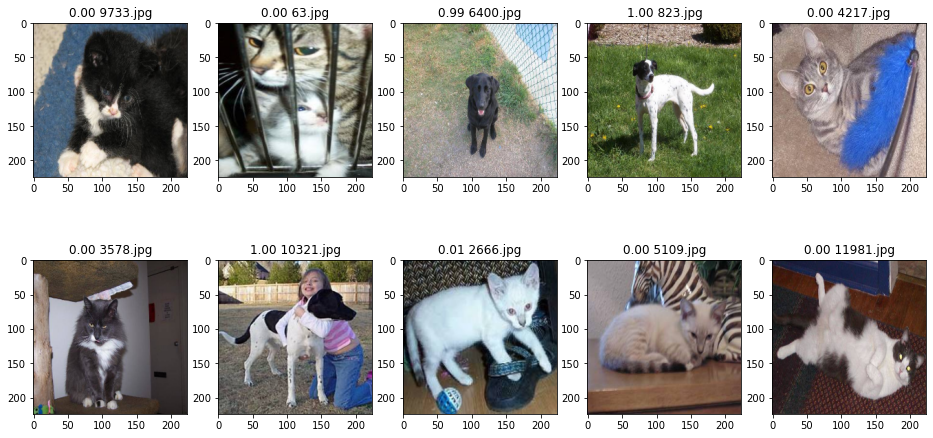

In [49]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

### Готовим данные для отправки

In [50]:
import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%s\n' % (re.search('(\d+).jpg$', path).group(1), score[0]))

